# 一、多层感知机（在网络中加入隐藏层）

我们可以通过在网络中加入一个或多个隐藏层来克服线性模型的限制，
使其能处理更普遍的函数关系类型。
要做到这一点，最简单的方法是将许多全连接层堆叠在一起。
每一层都输出到上面的层，直到生成最后的输出。
我们可以把前$L-1$层看作表示，把最后一层看作线性预测器。
这种架构通常称为*多层感知机*（multilayer perceptron），通常缩写为*MLP*。
下面，我们以图的方式描述了多层感知机（ :numref:`fig_mlp`）。

![一个单隐藏层的多层感知机，具有5个隐藏单元](./img/mlp.svg)

这个多层感知机有4个输入，3个输出，其隐藏层包含5个隐藏单元。
输入层不涉及任何计算，因此使用此网络产生输出只需要实现隐藏层和输出层的计算。
因此，这个多层感知机中的层数为2。
注意，这两个层都是全连接的。
每个输入都会影响隐藏层中的每个神经元，
而隐藏层中的每个神经元又会影响输出层中的每个神经元。

# 从线性到非线性

矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$
来表示$n$个样本的小批量，
其中每个样本具有$d$个输入特征。
有$h$个隐藏单元的单隐藏层多层感知机，
用$\mathbf{H} \in \mathbb{R}^{n \times h}$表示隐藏层的输出，  
因为隐藏层和输出层都是全连接的，
所以我们有隐藏层权重$\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$
和隐藏层偏置$\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
以及输出层权重$\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$
和输出层偏置$\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$。
形式上，我们按如下方式计算单隐藏层多层感知机的输出
$\mathbf{O} \in \mathbb{R}^{n \times q}$：
$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

为了构建更通用的多层感知机，
我们可以继续堆叠这样的隐藏层，
例如$\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$和$\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$，
一层叠一层，从而产生更有表达能力的模型。

# 激活函数（activation function）
通过计算加权和并加上偏置来确定神经元是否应该被激活，
它们将输入信号转换为输出的可微运算。
大多数激活函数都是非线性的。
由于激活函数是深度学习的基础，下面(**简要介绍一些常见的激活函数**)。

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## ReLU函数
给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

**$$\operatorname{ReLU}(x) = \max(x, 0).$$**

通俗地说，ReLU函数通过将相应的活性值设为0，仅保留正元素并丢弃所有负元素。

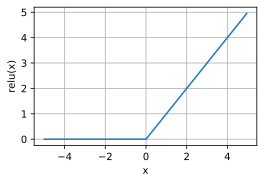

In [2]:
# 数值图像
x = torch.arange(-5.0, 5.0, 0.05, requires_grad=True)
y = torch.relu(x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(4, 2.5))
# 注：可以理解为是对y=x的一种优化，能够更多的划分任务


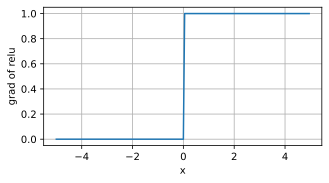

In [3]:
# 对应的导数图像
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

此外还有对于sign的改进函数sigmoid（）：
**$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$**

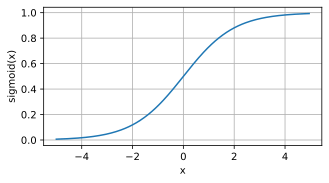

In [4]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

双正切函数tanh（）：
**$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$**

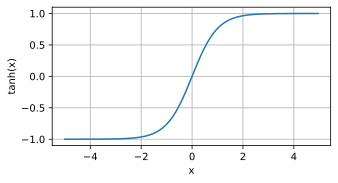

In [5]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

# 二、多层感知机的从零实现

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

In [7]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [8]:
# 为参数配置内存，计算上更加高效。
# 初始化，还是之前的数据集
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [9]:
# 定义激活函数，我们选择ReLU（）
def ReLU(X):
    a = torch.zeros(X.shape)
    return torch.max(a, X)

# 定义模型
def net(X):
    X = X.reshape((-1, num_inputs))  #input是特征维度，这一段是把张量展平
    H = ReLU(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

# 使用API接口计算交叉熵损失
loss = nn.CrossEntropyLoss(reduction='none')

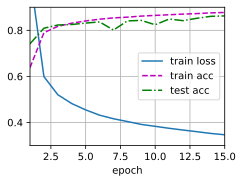

In [10]:
# 接下来就是训练
num_epochs, lr = 15, 0.1
updater = torch.optim.SGD(params, lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

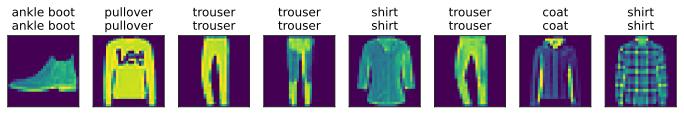

In [11]:
d2l.predict_ch3(net, test_iter, n=8)